In [1]:
from dotenv import load_dotenv
import os
import getpass

load_dotenv()

True

In [2]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

In [3]:
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your LangSmith API key: ")
os.environ["LANGSMITH_TRACING"] = "true"

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
)

In [5]:
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

In [6]:
python_repl = PythonREPL()

In [7]:
from langchain_experimental.utilities import PythonREPL
import sys
from io import StringIO

class PersistentPythonREPLTool(PythonREPL):
    def __init__(self):
        super().__init__()
        self._globals = {}

    def run(self, command: str) -> str:
        # Capture stdout
        old_stdout = sys.stdout
        sys.stdout = captured_output = StringIO()
        
        try:
            # First try eval (single expression)
            result = eval(command, self._globals)
            output = captured_output.getvalue()
            if output:
                return output + str(result)
            return str(result)
        except SyntaxError:
            # If it's a statement block, use exec
            try:
                exec(command, self._globals)
                output = captured_output.getvalue()
                return output if output else "Executed successfully with no output."
            except Exception as e:
                output = captured_output.getvalue()
                return output + repr(e) if output else repr(e)
        except Exception as e:
            output = captured_output.getvalue()
            return output + repr(e) if output else repr(e)
        finally:
            # Restore stdout
            sys.stdout = old_stdout

In [8]:
repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be" \
                " a valid python command. If you want to see the output of a value, you " \
                "should print it out with `print(...)`.",
    func=python_repl.run,
)

In [9]:
from langchain_core.tools import tool

@tool(name_or_callable="generate_hint", description="Generate a helpful hint for a DSA problem without solving it.")
def generate_hint(question: str) -> str:
    """Generate a helpful hint for a DSA problem without solving it.
    input: question (str): The DSA problem to generate a hint for.
    output: str: A helpful hint for the DSA problem."""
    
    return llm.invoke(f"Give a helpful hint for this DSA problem without solving it: {question}").content

In [10]:
@tool(name_or_callable="generate_test_cases", description="Generate test cases for DSA problems without solving them.")
def generate_test_cases(problem_description: str) -> str:
    """Use this to generate test cases for DSA problems.
    input: problem_description - the DSA problem statement
    output: 3 test cases without solving the problem"""
    
    return llm.invoke(f"Create 3 test cases for this DSA problem without solving it: {problem_description}").content

In [11]:
@tool(name_or_callable="bug_hint_tool", description="Analyze code for logic issues and provide a subtle hint.")
def bug_hint_tool(code: str) -> str:
    """Use this to analyze code for logic issues and provide a subtle hint.
    input: code - the code to analyze
    output: str - a subtle hint about potential logic issues in the code.
    """

    return llm.invoke(f"Analyze this code for logic issues and give a subtle hint: {code}").content

In [12]:
@tool(name_or_callable="complexity_analyzer", description="Analyze time and space complexity of code")
def complexity_analyzer(code: str) -> str:
    """Analyze the time and space complexity of the given code."""
    prompt = f"""Analyze the time and space complexity of this code. Provide:
    1. Time complexity with explanation
    2. Space complexity with explanation
    3. Suggestions for optimization if any
    
    Code: {code}"""
    return llm.invoke(prompt).content

In [13]:
@tool(name_or_callable="code_quality_checker", description="Check code quality and suggest improvements")
def code_quality_checker(code: str) -> str:
    """Check code quality and suggest improvements."""
    prompt = f"""Review this code for:
    1. Readability and style
    2. Edge case handling
    3. Variable naming
    4. Code structure
    
    Code: {code}"""
    return llm.invoke(prompt).content

In [14]:
@tool(name_or_callable="recommend_problems", description="Recommend next problems based on progress")
def recommend_problems(current_topic: str = "", difficulty: str = "medium") -> str:
    """Recommend problems based on learning progression."""
    
    prompt = f"""Based on the current topic '{current_topic}' and difficulty '{difficulty}', 
    recommend 3 specific DSA problems that would be good next steps for learning. 
    Include problem names and brief descriptions."""
    
    return llm.invoke(prompt).content

In [15]:
@tool(name_or_callable="create_study_plan", description="Create personalized DSA study plan")
def create_study_plan(timeline_weeks: str, current_level: str, target_goals: str) -> str:
    """Create a personalized study plan for DSA preparation."""
    prompt = f"""Create a {timeline_weeks}-week DSA study plan for someone at {current_level} level 
    with goals: {target_goals}. Include:
    1. Week-by-week topics
    2. Number of problems per topic
    3. Key concepts to master
    4. Milestones to track progress"""
    
    return llm.invoke(prompt).content

In [16]:
tools = [
    repl_tool, 
    generate_hint, 
    generate_test_cases, 
    bug_hint_tool,
    complexity_analyzer,
    code_quality_checker,
    recommend_problems,
    create_study_plan
]

In [17]:
llm_with_tools = llm.bind_tools(tools)

In [18]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage,SystemMessage,AnyMessage
from langgraph.graph import StateGraph, START

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


In [19]:
sys_msg = SystemMessage(content=(
    "You are an expert DSA mentor using the Socratic method. Your goal is to guide students through problem-solving by asking questions and using tools proactively.\n\n"
    
    "CORE PRINCIPLES:\n"
    "1. NEVER give direct solutions - guide through questions and hints\n"
    "2. ALWAYS use tools proactively based on context, not just when asked\n"
    "3. Engage in meaningful conversations about problem-solving approach\n\n"
    
    "WHEN TO USE TOOLS AUTOMATICALLY:\n"
    "- When user shares a problem statement → use `generate_hint` and `generate_test_cases`\n"
    "- When user shares code → use `bug_hint_tool` to check for issues\n"
    "- After code is working → use `complexity_analyzer` and `code_quality_checker`\n"
    "- When user seems stuck → use `recommend_problems` for easier problems\n"
    "- When user wants to learn a topic → use `create_study_plan`\n"
    "- When testing solutions → use `python_repl` to run and verify code\n"
    
    "PROBLEM-SOLVING METHODOLOGY:\n"
    "1. Understand the problem (ask clarifying questions)\n"
    "2. Generate test cases (use `generate_test_cases`)\n"
    "3. Think of examples and edge cases\n"
    "4. Consider different approaches (use `generate_hint`)\n"
    "5. Implement solution step by step\n"
    "6. Test implementation (use `python_repl`)\n"
    "7. Debug if needed (use `bug_hint_tool`)\n"
    "8. Analyze complexity (use `complexity_analyzer`)\n"
    "9. Review code quality (use `code_quality_checker`)\n\n"
    
    "CONVERSATION FLOW:\n"
    "- Start each new problem by automatically generating hints and test cases\n"
    "- Ask probing questions about their approach\n"
    "- Use visualization tools to explain concepts\n"
    "- Run code automatically when they share solutions\n"
    "- Provide complexity analysis once code works\n"
    "- Recommend next problems based on progress\n\n"
    
    "Remember: Be proactive with tools to create an engaging learning experience!"
))

In [20]:
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import MessagesState

In [21]:
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [22]:
graph = StateGraph(State)
graph.add_node("assistant", assistant)
graph.add_node("tools", ToolNode(tools))
graph.add_edge(START,"assistant")
graph.add_conditional_edges("assistant", tools_condition)
graph.add_edge("tools", "assistant")

In [23]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [24]:
app=graph.compile(checkpointer=memory)

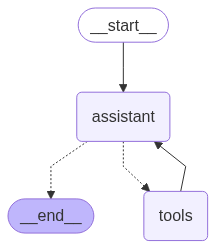

In [25]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "123"}}

while True:
    # Get user input
    user_input = input("\nYou: ").strip()
    if user_input.lower() in {"exit", "quit", "cancel"}:
        print("Conversation ended.")
        break

    # Wrap input as a HumanMessage
    initial_input = {"messages": [HumanMessage(content=user_input)]}

    # Stream app output
    for event in app.stream(initial_input, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()


================================ Human Message =================================

two sum problem
================================== Ai Message ==================================

Great! The "Two Sum" problem is a classic. Let's break it down.

First, to make sure we're on the same page, could you describe the problem in your own words?

In the meantime, here are some hints and test cases to get us started:
Tool Calls:
  generate_hint (41fc9977-f2d0-45c7-b92b-bdbe824e01b0)
 Call ID: 41fc9977-f2d0-45c7-b92b-bdbe824e01b0
  Args:
    question: Two Sum problem
  generate_test_cases (501e0097-ec08-437c-96ea-e0957c3485ad)
 Call ID: 501e0097-ec08-437c-96ea-e0957c3485ad
  Args:
    problem_description: Two Sum problem
================================= Tool Message =================================
Name: generate_test_cases

Okay, here are 3 test cases for the Two Sum problem, without providing the solution logic itself.

---

**Problem Description Reminder:**
Given an array of integers `nums` 